# DEA CoastLines utility functions

## Load modules/functions


In [1]:
!pip install owslib

import os
import uuid
import subprocess
import pandas as pd
import xarray as xr
import geopandas as gpd 
import matplotlib.pyplot as plt
import matplotlib.colors as colors

from shapely.geometry import box, shape

# Widgets and WMS
from odc.ui import ui_poll, select_on_a_map
from ipyleaflet import (Map, WMSLayer, WidgetControl, FullScreenControl, 
                        DrawControl, basemaps, basemap_to_tiles, TileLayer)
from ipywidgets.widgets import Layout, Button, HTML
from owslib.wms import WebMapService
from IPython.display import display
from types import SimpleNamespace

        
def wms_layers_styles(url):
    """
    Returns a dataframe of available layer styles for a given WMS
    """
    
    # Get WMS data from URL
    wms_items = dict(WebMapService(url, version='1.3.0').items())
    
    return wms_items
    layers_styles = {key: val.styles.keys() for key, val in wms_items.items()}

    # Create a dataframe with an index of layer names and list of styles
    layers_df = pd.DataFrame(index=layers_styles.keys())
    layers_df['styles'] = layers_styles.values()
    layers_df.index.name = 'layer'
    
    # Print output
    with pd.option_context('display.max_rows', None, 
                           'display.max_colwidth', 255):
        display(layers_df)
    
    return layers_df


def wms_xarray(url, 
               layer, 
               bbox, 
               layerstyle, 
               layertime,                
               layerformat='png', 
               layersizex=512, 
               layersizey=512,
               epsg='EPSG:4326'):
    """
    Loads WMS data as an xarray.Dataset object.
    """

    # Get extent
    y_max, x_min, y_min, x_max = bbox

    # Create tempory path files
    unique_id = str(uuid.uuid4())
    infile = f'{unique_id}.tif'
    outfile = f'{unique_id}_georef.tif'

    wms = WebMapService(url, version='1.3.0')
    crs = sorted(wms[layer].crsOptions)
    time = wms[layer].timepositions
    
    output = wms.getmap(layers=[layer],
                styles=[layerstyle],
                srs='EPSG:4326',
                bbox=(x_min, y_min, x_max, y_max),
                size=(layersizex, layersizey),
                format='image/'+layerformat,
                time=layertime
                )
            
    with open(infile, 'wb') as out:
        out.write(output.read())   
   
    # TODO write as python rather than system call
    subprocess.call(['gdal_translate','-a_srs', epsg, 
                     '-a_ullr', str(x_min), str(y_max), str(x_max), str(y_min), 
                     infile, outfile])
    ds = xr.open_rasterio(outfile)
    
    # Remove temporary rasters
    os.remove(outfile)
    os.remove(infile)
    
    return(ds)


def polyline_select(center=(-26, 135),
                    zoom=4,
                    height='500px'):
    """
    Allows the user to interactively draw a polyline on the map with a 
    DEA CoastLines overlay.
    """    
  
    def update_info(txt):
        html_info.value = '<pre style="color:grey">' + txt + '</pre>'

    def render_bounds(bounds):
        (lat1, lon1), (lat2, lon2) = bounds
        txt = 'lat: [{:.{n}f}, {:.{n}f}]\nlon: [{:.{n}f}, {:.{n}f}]'.format(
            lat1, lat2, lon1, lon2, n=4)
        update_info(txt)
        
    def on_done(btn):
        state.done = True
        btn_done.disabled = True
        m.remove_control(draw)
        for w in widgets:
            m.remove_control(w)

    def bounds_handler(event):
        bounds = event['new']
        render_bounds(bounds)
        (lat1, lon1), (lat2, lon2) = bounds
        state.bounds = dict(lat=(lat1, lat2),
                            lon=(lon1, lon2))

    def on_draw(event):
        v = event['new']
        action = event['name']
        if action == 'last_draw':
            state.selection = v['geometry']
        elif action == 'last_action' and v == 'deleted':
            state.selection = None

        btn_done.disabled = state.selection is None
        

    state = SimpleNamespace(selection=None,
                            bounds=None,
                            done=False)
    
    # Set up "Done" button
    btn_done = Button(description='done',
                      layout=Layout(width='5em'))
    btn_done.style.button_color = 'green'
    btn_done.disabled = True

    html_info = HTML(layout=Layout(flex='1 0 20em',
                                   width='20em',
                                   height='3em'))

    # Load DEACoastLines WMS
    deacl_url='https://geoserver.dea.ga.gov.au/geoserver/wms'
    deacl_layer='dea:DEACoastLines'
    wms = WMSLayer(url=deacl_url,
                   layers=deacl_layer,
                   format='image/png',
                   transparent=True,
                   attribution='DEA CoastLines © 2020 Geoscience Australia')
    
    # Plot interactive map to select area
    basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
    places = TileLayer(url=('https://server.arcgisonline.com/ArcGIS/rest/'
                            'services/Reference/World_Boundaries_and_Places'
                            '/MapServer/tile/{z}/{y}/{x}'), opacity=1)
    m = Map(layers=(basemap, wms, places, ),
            height=height,
            center=center, 
            zoom=zoom)
    m.scroll_wheel_zoom = True

    # Set up done and info widgets
    widgets = [WidgetControl(widget=btn_done, position='topright'),
               WidgetControl(widget=html_info, position='bottomleft')]
    for w in widgets:
        m.add_control(w) 
        
    # Add polyline draw control option
    draw = DrawControl(circlemarker={}, polygon={})
    m.add_control(draw)
    m.add_control(FullScreenControl())
    draw.polyline =  {'shapeOptions': {'color': 'red', 'opacity': 1.0}}

    # Set up interactivity
    draw.observe(on_draw)
    m.observe(bounds_handler, ('bounds',))
    btn_done.on_click(on_done)

    return m, state


def deacl_transect(transect_mode='distance',
                   export_data=None,
                   length_limit=50):
    
    """
    Function for interactively drawing a transect line on a map,
    and using this line to extract distances to each annual DEA 
    CoastLines coastline along the transect. The function can also be
    used to measure the width between two coastlines from the same year
    through time.
    
    Parameters
    ----------
    transect_mode : string, optional
        An optional string indicating whether to analyse coastlines 
        using 'distance' or 'width' mode. The "distance" mode measures the 
        distance from the start of the transect to each of the annual
        coastlines, and will ignore any coastline that intersects the 
        transect more than once. The 'width' mode will measure the 
        width between two coastlines from the same year, which can be
        useful for measuring e.g. the width of a tombolo or sandbank 
        through time. This mode will ignore any annual coastline that 
        intersections with the transect only once.
    export_data : string, optional
        An optional string giving the file path to export the output 
        transect data as a CSV file. The default is 'None, which will 
        not export data.
    """
    
    # Run interactive map
    m, state = polyline_select()
    display(m)
    
    def extract_geometry(state):        
        
        # Convert geometry to a GeoSeries
        profile = gpd.GeoSeries(shape(state.selection), 
                                crs='EPSG:4326')  
        
        # Test length
        transect_length = (profile.to_crs('EPSG:3577').length / 1000).sum()
        if transect_length > length_limit:
            raise ValueError(f'Your transect is {transect_length:.0f} km long. '
                             f'Please draw a transect that is less than '
                             f'{length_limit} km long.\nTo draw a shorter '
                             f'transect, re-run the cell above and draw a new '
                             f'polyline.')

        # Load data from WFS
        print('Loading DEA CoastLines data...')
        xmin, ymin, xmax, ymax = profile.total_bounds
        deacl_wfs = f'https://geoserver.dea.ga.gov.au/geoserver/wfs?service=WFS' \
                    f'&version=1.1.0&request=GetFeature&typeName=dea:coastlines' \
                    f'&srsName=EPSG%3A3577&maxFeatures=1000' \
                    f'&bbox={ymin},{xmin},{ymax},{xmax}'
        deacl = gpd.read_file(deacl_wfs)
        deacl.crs = 'EPSG:3577'

        # Raise exception if no coastlines are returned
        if len(deacl.index) == 0:
            raise ValueError('No annual coastlines were returned for the '
                             'supplied transect. Please select another area.')
            
        # Dissolve by year to remove duplicates, then sort by date
        deacl = deacl.dissolve(by='year', as_index=False)
        deacl['year'] = deacl.year.astype(int)
        deacl = deacl.sort_values('year')

        # Extract intersections and determine type
        profile = profile.to_crs('EPSG:3577')
        intersects = deacl.apply(lambda x: profile.intersection(x.geometry), axis=1)
        intersects = gpd.GeoSeries(intersects[0])   
        
        # Select geometry depending on mode
        intersects_type = (intersects.type == 'Point' if 
                           transect_mode == 'distance' else 
                           intersects.type == 'MultiPoint')

        # Remove annual data according to intersections
        deacl_filtered = deacl.loc[intersects_type]
        drop_years = ', '.join(deacl.year
                               .loc[~intersects_type]
                               .astype(str)
                               .values.tolist())

        # In 'distance' mode, analyse years with one intersection only
        if transect_mode == 'distance':  
            
            if drop_years:
                print(f'Dropping years due to multiple intersections: {drop_years}')

            # Add start and end coordinate
            deacl_filtered = deacl_filtered.assign(
                start=profile.interpolate(0).iloc[0])
            deacl_filtered['end'] = intersects.loc[intersects_type]

        # In 'width' mode, analyse years with multiple intersections only
        elif transect_mode == 'width':

            if drop_years:
                print(f'Dropping years due to less than two intersections: {drop_years}')

            # Add start and end coordinate
            deacl_filtered = deacl_filtered.assign(
                start=intersects.loc[intersects_type].apply(lambda x: x[0]))
            deacl_filtered['end'] = intersects.loc[intersects_type].apply(
                lambda x: x[1])

        # If any data was returned:
        if len(deacl_filtered.index) > 0:    

            # Compute distance
            deacl_filtered['dist'] = deacl_filtered.apply(
                lambda x: x.start.distance(x.end), axis=1)

            # Extract values
            transect_df = pd.DataFrame(deacl_filtered[['year', 'dist']])

            # Plot data
            fig, ax = plt.subplots(1, 1, figsize=(5, 8))
            transect_df.plot(x='dist', y='year', ax=ax)
            ax.invert_yaxis()
            ax.set_xlabel(f'{transect_mode.title()} (metres)')
            plt.show()

            # Optionally write output data
            if export_data:
                transect_df.to_csv(export_data, index=False)

            return transect_df

        else:
            raise ValueError('No valid intersections found for transect')

    return ui_poll(lambda: extract_geometry(state) if state.done else None)


def rates_hist(extent_path=None,
               cmap='RdBu',
               hist_log=True, 
               hist_bins=60, 
               hist_range=(-30, 30),
               export_figure=None,
               size_limit=100000,
               max_features=100000):
    """
    Function for interactively selecting and analysing DEACoastLines 
    statistics point data, and plotting results as histograms to 
    compare rates of change.
    
    Parameters
    ----------
    extent_path : string, optional
        An optional path to a shapefile or other vector file that will 
        be used to extract a subset of DEACoastLines statistics. The 
        default is None, which will select a subset of data using an 
        interactive map.
    hist_log : boolean, optional
        An optional boolean indicating whether to plot histograms with 
        a log y-axis. If True, all non-significant statistics points 
        will be assigned a rate of 0 metres / year. If False, all 
        non-significant points will be removed from the dataset, and 
        plotted with a linear y-axis. 
    hist_bins : int, optional
        Number of bins to plot on the histogram. Defaults to 60.
    hist_range : tuple, optional
        A tuple giving the min and max range to plot on the x-axis.
    export_figure : string, optional
        An optional string giving the file path to export the output 
        figure to as an image. The default is None, which will not 
        export an image.
    size_limit : int, optional
        An optional size limit for the area selection in sq km. 
        Defaults to 100,000 sq km.
    max_features : int, optional
        The maximum number of DEACoastLines statistics points to 
        return from the WFS query. The default is 100,000.
    """
    
    #############
    # Load data #
    #############
    
    # Load polygon from file if path is provided
    if extent_path:
        extent = gpd.read_file(extent_path).to_crs('EPSG:4326')

    # Otherwise, use interactive map to select region
    else:        
        
        # Load DEACoastLines WMS
        deacl_url='https://geoserver.dea.ga.gov.au/geoserver/wms'
        deacl_layer='dea:DEACoastLines'
        wms = WMSLayer(url=deacl_url,
                       layers=deacl_layer,
                       format='image/png',
                       transparent=True,
                       attribution='DEA CoastLines © 2020 Geoscience Australia')
        
        # Plot interactive map to select area
        basemap = basemap_to_tiles(basemaps.Esri.WorldImagery)
        places = TileLayer(url=('https://server.arcgisonline.com/ArcGIS/rest/'
                               'services/Reference/World_Boundaries_and_Places'
                               '/MapServer/tile/{z}/{y}/{x}'), opacity=1)
        geopolygon = select_on_a_map(height='500px',
                                     layers=(basemap, wms, places, ),
                                     center=(-26, 135), 
                                     zoom=4) 

        # Covert extent object to geopandas.GeoSeries object with CRS
        extent = gpd.GeoDataFrame(geometry=[geopolygon], crs='EPSG:4326')   
        
    # Verify size
    area = (extent.to_crs(crs='epsg:3577').area / 1000000).sum()
    if area > size_limit:
        raise ValueError(f'Your selected area is {area:.00f} sq km. '
                         f'Please select an area of less than {size_limit} sq km.'
                         f'\nTo select a smaller area, re-run the cell '
                         f'above and draw a new polygon.')
    
    # Load data from WFS
    print('Loading DEA CoastLines data...')
    xmin, ymin, xmax, ymax = extent.total_bounds
    deacl_wfs = f'https://geoserver.dea.ga.gov.au/geoserver/wfs?service=WFS' \
                f'&version=1.1.0&request=GetFeature&typeName=dea:coastlines_statistics' \
                f'&srsName=EPSG%3A3577&maxFeatures={max_features}' \
                f'&bbox={ymin},{xmin},{ymax},{xmax}'
    stats_subset = gpd.read_file(deacl_wfs)
    stats_subset.crs = 'EPSG:3577'
    
    # Clip resulting data to extent shape
    if len(stats_subset.index) > 0:
        stats_subset = gpd.overlay(stats_subset, extent.to_crs('EPSG:3577'))
    
    # Raise exception if no points are returned
    if len(stats_subset.index) == 0:
        raise ValueError('No statistics points were returned for the supplied '
                         'extent. Please select another area.')
        
    #############
    # Plot data #
    #############

    if hist_log:

        print('Plotting data with log axis after setting non-significant points to 0 m / year')
        stats_subset.loc[stats_subset.sig_time > 0.01, 'rate_time'] = 0
        bin_offset = (hist_range[1] - hist_range[0]) / (hist_bins / 0.5)

    else:
        print('Plotting data with linear axis after filtering to significant values')
        stats_subset = stats_subset.loc[stats_subset.sig_time < 0.01]
        bin_offset = 0

    # Select colormap
    cm = plt.cm.get_cmap(cmap)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    ax1.grid(True, which="both", axis='y', color='0.9')
    ax1.set_axisbelow(True)

    # Plot histogram    
    n, bins, patches = ax1.hist(stats_subset.rate_time, 
                                bins=hist_bins, 
                                range=[(a + bin_offset) for a in hist_range], 
                                log=hist_log,
                                edgecolor='black')

    # Scale values to interval [0,1]
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    norm = colors.SymLogNorm(linthresh=0.25, 
                             linscale=0.05,
                             vmin=hist_range[0], 
                             vmax=hist_range[1], 
                             base=10)
    col = norm(bin_centers)  

    # Apply colors to bars
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

    ax1.set_title(f'Mean rate: {stats_subset.rate_time.mean():.2f} m / year')
    ax1.set_xlabel('Rate of change (m / year)')
    ax1.set_ylabel('Frequency')
    
    minx, miny, maxx, maxy = stats_subset.to_crs('epsg:4326').total_bounds
    midx = (minx + maxx) / 2.0
    midy = (miny + maxy) / 2.0
    width_r = (maxx - minx) / 2.0
    height_r = (maxy - miny) / 2.0
    radius = max(width_r, height_r)
    wms_extent = [midy + radius, midx - radius, midy - radius, midx + radius]
    
    ds = wms_xarray(url="https://gsky.nci.org.au/ows/dea",  #WMS for background image
                    layer="landsat8_geomedian",  #WMS layer name
                    bbox=wms_extent, 
                    layerstyle='tc',
                    layertime='2018-01-01T00:00:00.000Z')
    ds.isel(band=[0, 1, 2]).plot.imshow(ax=ax2, 
                                        alpha=0.3, 
                                        add_labels=False)  
    
    ax2.set_title('DEACoastLines statistics points')
    
    # Plot vector points
    stats_subset = (stats_subset
                    .to_crs('EPSG:4326')
                    .reindex(stats_subset
                             .rate_time.abs()
                             .sort_values(ascending=True).index))
    stats_subset.plot(ax=ax2, 
                      column='rate_time', 
                      norm=norm, 
                      cmap=cmap, 
                      edgecolor='0.8',
                      linewidth=0.2,
                      markersize=20) 
    
    # Optionally export figure
    if export_figure:
        print(f'Exporting figure to {export_figure}')
        plt.savefig(export_figure, bbox_inches='tight')
    
    # Return point data
    return stats_subset
    

## Statistics point histogram analysis
1. Run the cell below; an interactive map will appear 
2. Use the `Draw a polygon` or `Draw a rectangle` tools on the left to select a region.
3. Press `Done` in the top right when ready
4. A histogram plot will appear below the map

> **Optional:** Set `hist_log=True` and re-run the cell below to generate a log-scale histogram plot
   
> **Optional:** Instead of using the interactive map, supply a path to a vector file using the `extent_path` parameter (e.g. `extent_path='study_area.shp`). The vector file must contain only one polygon.



Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Loading DEA CoastLines data...
Plotting data with linear axis after filtering to significant values
Exporting figure to output.png


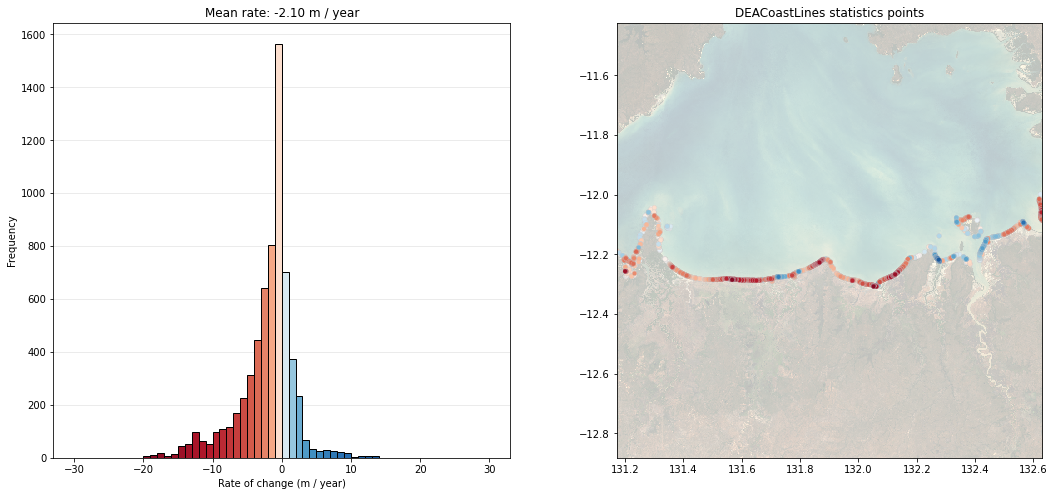

In [2]:
df = rates_hist(extent_path=None,
                hist_log=False,
                export_figure='output.png')

## Interactive profile selection
1. Run the cell below; an interactive map will appear 
2. Zoom in and use the `Draw a polyline` tool on the left to draw a transect across a set of coastlines
3. Press `Finish` when you are happy with the line, then click `Done` in the top right
4. A graph will appear below the map showing distances along the transect to each annual coastline (distances will be measured from the start of the transect line you drew above)

> **Optional:** Set `transect_mode='width'` and re-run the cell below to measure the width between two adjacent sets of coastlines (e.g. across the next of a tombolo or sandbar)

Map(center=[-26, 135], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

Loading DEA CoastLines data...


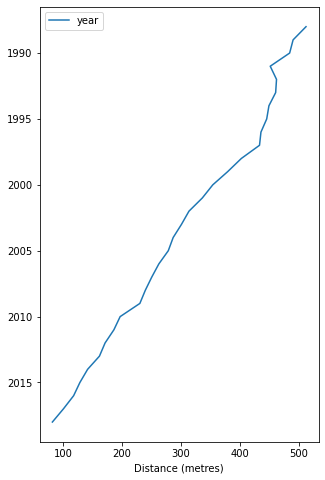

In [3]:
df = deacl_transect(transect_mode='distance',
                    export_data='deacl_transect.csv')


***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** July 2020